## Goal of Analysis:

#### 1. a full picture of funnel conversion rate for both desktop and mobile

#### 2. some insights to product team on how to improve conversion rate

### Part 1: data preprocessing

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
home_page_table = pd.read_csv('home_page_table.csv')
payment_confirmation_table = pd.read_csv('payment_confirmation_table.csv')
payment_page_table = pd.read_csv('payment_page_table.csv')
search_page_table = pd.read_csv('search_page_table.csv')
user_table = pd.read_csv('user_table.csv')

In [3]:
user_table.head()

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


In [4]:
# all the page table is about the user id and each corresponding page, 

search_page_table.head()

,user_id,page
0,15866,search_page
1,347058,search_page
2,577020,search_page
3,780347,search_page
4,383739,search_page


In [5]:
# I will try to combine them to have a full picture

data = pd.merge(left=user_table, right=home_page_table, how='left', on='user_id')
data = pd.merge(left=data, right=search_page_table, how='left', on='user_id', suffixes=('_home', '_search'))
data = pd.merge(left=data, right=payment_page_table, how='left', on='user_id')
data = pd.merge(left=data, right=payment_confirmation_table, how='left', on='user_id', 
                suffixes=('_payment', '_confirmation'))

data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [6]:
data.describe()

,user_id
count,90400.000000
mean,498709.683473
std,289040.674085
min,17.000000
25%,247978.750000
50%,498267.000000
75%,749789.250000
max,999979.000000


In [7]:
data.dtypes

user_id               int64
date                 object
device               object
sex                  object
page_home            object
page_search          object
page_payment         object
page_confirmation    object
dtype: object

### Part 2: Funnel Analysis

In [8]:
# First, we will take a look at the visit page conversion rate

conv_ratio = 1 - pd.DataFrame(data.isnull().sum()).rename(columns={0: 'conversion'}) / len(data)
conv_ratio = conv_ratio.reset_index()[4:]
conv_ratio

,index,conversion
4,page_home,1.000000
5,page_search,0.500000
6,page_payment,0.066704
7,page_confirmation,0.005000


We can see that the conversion rate is decreasing from home page to search to payment and to pament confirmation, that is the quite normal as payment confirmation is the last step of purchase

we will then visualize the data to see it more straight forward

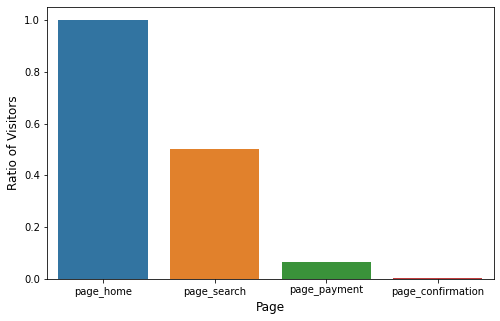

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='index', y='conversion', data=conv_ratio, ax=ax)
ax.set_xlabel('Page', fontsize=12)
ax.set_ylabel('Ratio of Visitors', fontsize=12)
plt.show()

Next, I will breakdown each page's conversion rate for more insights

In [10]:
# First define a function

def conversion_rate(df):
    """ function to calculate conversion rates for home, search and payment page"""
    rates = []
    tmp = df[~df['page_home'].isnull()]
    rates.append(1 - tmp['page_search'].isnull().sum() / len(tmp))
    
    tmp = df[~df['page_search'].isnull()]
    rates.append(1 - tmp['page_payment'].isnull().sum() / len(tmp))
    
    tmp = df[~df['page_payment'].isnull()]
    rates.append(1 - tmp['page_confirmation'].isnull().sum() / len(tmp))
    
    return rates

### Overall home page

In [11]:
rates = conversion_rate(data)
names = ['home', 'search', 'payment']
maps = {'Page': ['home', 'search', 'payment'], 'Conversion Rate': rates}
overall_conv = pd.DataFrame(maps, columns=['Page', 'Conversion Rate'])

overall_conv

,Page,Conversion Rate
0,home,0.500000
1,search,0.133407
2,payment,0.074959


## For each device

In [12]:
data['device'].unique()

array(['Desktop', 'Mobile'], dtype=object)

we will breakdown the device into desktop and mobile

In [13]:
desk_rates = conversion_rate(data[data['device'] == 'Desktop'])
mobile_rates = conversion_rate(data[data['device'] == 'Mobile'])
names = ['home', 'search', 'payment']
print('{0:^10s} | {1:^10s} | {2:^10s}'.format('Page', 'Desktop', 'Mobile'))
print('-' * 40)
for name, desk_rate, mobile_rate in zip(names, desk_rates, mobile_rates):
    print('{0:10s} | {1:10.6f} | {2:10.6f}'.format(name, desk_rate, mobile_rate))

   Page    |  Desktop   |   Mobile  
----------------------------------------
home       |   0.500000 |   0.500000
search     |   0.100000 |   0.200000
payment    |   0.049834 |   0.100000


In [14]:
# Visualization
maps = {'Page': ['home', 'search', 'payment', 'home', 'search', 'payment'], 
        'Device': ['Desktop', 'Desktop', 'Desktop', 'Mobile', 'Mobile', 'Mobile'], 
        'Conversion Rate': desk_rates + mobile_rates}
device_conv = pd.DataFrame(maps, columns=['Page', 'Device', 'Conversion Rate'])
device_conv

,Page,Device,Conversion Rate
0,home,Desktop,0.500000
1,search,Desktop,0.100000
2,payment,Desktop,0.049834
3,home,Mobile,0.500000
4,search,Mobile,0.200000
5,payment,Mobile,0.100000


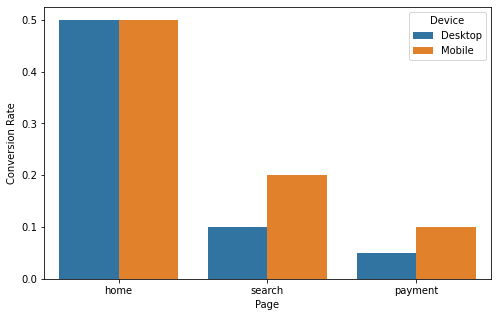

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='Page', y='Conversion Rate', data=device_conv, ax=ax, hue='Device')
plt.show()

It seems that mobile device will be more easily lead to a final payment than desktop

## For each gender

In [16]:
data['sex'].unique()

array(['Female', 'Male'], dtype=object)

In [17]:
male_rates = conversion_rate(data[data['sex'] == 'Male'])
female_rates = conversion_rate(data[data['sex'] == 'Female'])
names = ['home', 'search', 'payment']
print('{0:^10s} | {1:^10s} | {2:^10s}'.format('Page', 'Male', 'Female'))
print('-' * 40)
for name, male_rate, female_rate in zip(names, male_rates, female_rates):
    print('{0:10s} | {1:10.6f} | {2:10.6f}'.format(name, male_rate, female_rate))

   Page    |    Male    |   Female  
----------------------------------------
home       |   0.496944 |   0.503073
search     |   0.130083 |   0.136708
payment    |   0.072014 |   0.077742


In [18]:
# Visualization
maps = {'Page': ['home', 'search', 'payment', 'home', 'search', 'payment'], 
        'Sex': ['Male', 'Male', 'Male', 'Female', 'Female', 'Female'], 
        'Conversion Rate': male_rates + female_rates}
sex_conv = pd.DataFrame(maps, columns=['Page', 'Sex', 'Conversion Rate'])
sex_conv

,Page,Sex,Conversion Rate
0,home,Male,0.496944
1,search,Male,0.130083
2,payment,Male,0.072014
3,home,Female,0.503073
4,search,Female,0.136708
5,payment,Female,0.077742


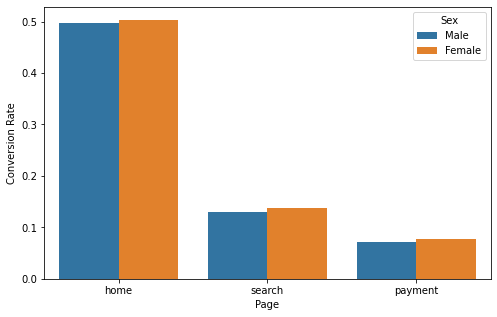

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='Page', y='Conversion Rate', data=sex_conv, ax=ax, hue='Sex')
plt.show()

Female will be more easily to place an order than male, but the difference is not as large as imagine

### Part 3: Insights to product team

1. from the home page to search, the cnversion rate is only 50%, the product team can do some modification to improve the customer experience on the search page

2. Mobile device have significantly higher conversion rate than desktop, we can consider do more promotion or enhance the user experience on mobile device

3. Female will be more likely to make a purchase than male, maybe consider more promotion on woman's products